<a href="https://colab.research.google.com/github/Esselle7/SINDY-ModelIdentificationFromData/blob/main/HRI_and_Thermostat_PySINDy_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SINDy Implementation with PySINDy

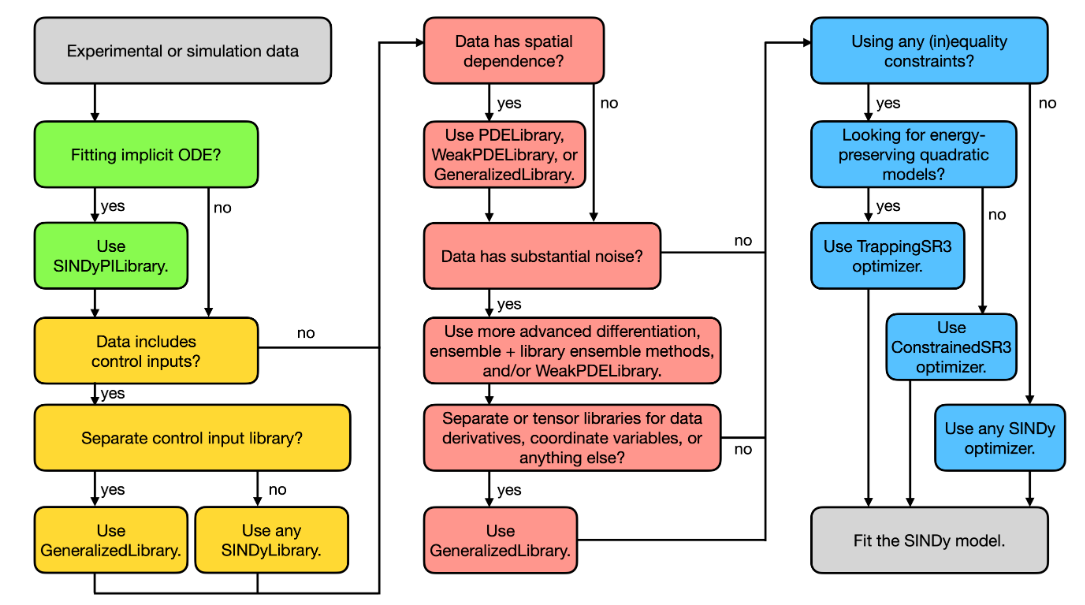

## Import libraries and function definitions

In [ ]:
!pip install pysindy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import math
from typing import List
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import pysindy as ps
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz
from sklearn.metrics import mean_squared_error
from scipy.signal import medfilt

import csv
from typing import Tuple
from pysindy import SINDy, SINDyDerivative
from pysindy.optimizers import STLSQ
from sklearn.linear_model import Lasso

## Model Learning

In this section, I define the known models that will be learned through a data-driven learning method (SINDy). Subsequently, I generate synthetic data within a given time interval using these known models. These synthetic data will constitute the training set for the SINDy model identification method. After completing the training, I will run a simulation to compare the obtained results with those generated by the known models in order to evaluate the effectiveness of the model identification method. This evaluation will be conducted through the study of the mean squared error (MSE).

In [ ]:
import matplotlib.pyplot as plt

def plot_versus(t_val, t_train_test, x_learned, x_test):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t_train_test, x_test, label='Real', color='r')
    ax.plot(t_val, x_learned, label='Learned', linestyle = "--", color='b')
    ax.set_xlabel('time')
    ax.set_ylabel('values')
    ax.legend()
    plt.title("Comparison between learned signal and real signal")
    plt.grid(True)
    plt.show()


In [ ]:
def plot_versus(t_val, t_train_test, x_learned, x_test):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.step(t_train_test, x_test, label='Real', color='r')
    ax.step(t_val, x_learned, label='Learned', color='b', linestyle="--")
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal Value')
    ax.legend()

    # Imposta tutti i bordi degli assi a nero e con uno spessore maggiore
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.0)  # Imposta uno spessore maggiore per il bordo esterno

    # Assicurati che gli assi formino un rettangolo completo
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    # Configura i tick e le etichette per il colore
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')

    plt.title('')
    plt.show()


In [ ]:
def plot_versus(t_val, t_train_test, x_learned, x_test):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.step(t_train_test, x_test, label='Real', color='r')
    ax.step(t_val, x_learned, label='Learned', color='b', linestyle = "--")
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    ax.legend()
    ax.spines['left'].set_position(('axes', 0))
    ax.spines['bottom'].set_position(('axes', 0))
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    ax.tick_params(axis='x', colors='gray')
    ax.tick_params(axis='y', colors='gray')
    ax.xaxis.label.set_color('gray')
    ax.yaxis.label.set_color('gray')
    ax.spines['left'].set_position(('axes', 0.045))

    plt.title('')
    plt.show()

### HRI - busy_model

(x0)' = -0.003 x0


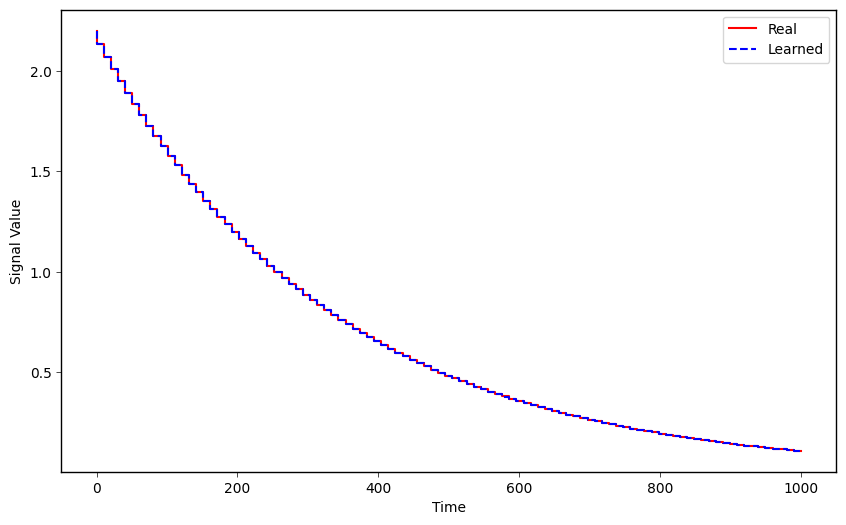

Model score: 1.000000


In [ ]:
def idle_model(interval, F_0):
  N_0 = (0.003, 0.0001, 100)
  return [F_0 * math.exp(-N_0[0] * (t - interval[0])) for t in interval]
F_0 = 2

# Definisco l'intervallo di tempo
t_val = np.linspace(0, 1000, 100)
t_train_test = np.linspace(0, 1000, 100)

# Genero i dati utilizzando la funzione busy_model
x_train = np.array(idle_model(t_train_test, F_0))
x_test = np.array(idle_model(t_train_test, F_0+0.2))
# Crea un modello PySINDy
stlsq_optimizer = ps.STLSQ(threshold=0.001)
model = ps.SINDy( optimizer=stlsq_optimizer) # che cosa ritorna questo costruttore, vettore di coeff e library funct.
model.fit(x_train, t_train_test, quiet=True)
model.print() # metodi di equivalenza tra parametri del modello (come misurare distanza tra funzioni).
# Genero i valori dal modello appreso partendo dalo stesso valore iniziale del modello noto
init_val = np.array([x_test[0]])
x_learned = model.simulate(init_val, t_val)
# Plotto il grafico del modello reale e del modello appreso
plot_versus(t_val, t_train_test, x_learned, x_test)
print("Model score: %f" % model.score(x_test, t_train_test))

In [ ]:
# Importo il modello
def busy_model(interval, F_0):
    N_1 = (0.004, 0.0004, 100)
    lambda_val = N_1[0]
    t_0 = interval[0]
    return [1 - (1 - F_0) * math.exp(-lambda_val * (t - t_0)) for t in interval]

# Valore iniziale del modello preso da L*SHA
F_0 = 50

In [ ]:
# Definisco l'intervallo di tempo
t_val = np.linspace(0, 1000, 100)
t_train_test = np.linspace(0, 1000, 100)

# Genero i dati utilizzando la funzione busy_model
x_train = np.array(busy_model(t_train_test, F_0))
x_test = np.array(busy_model(t_train_test, F_0+0.2))

In [ ]:
# Crea un modello PySINDy
stlsq_optimizer = ps.STLSQ(threshold=0.0001)
model = ps.SINDy(optimizer=stlsq_optimizer) # che cosa ritorna questo costruttore, vettore di coeff e library funct.
model.fit(x_train, t_train_test, quiet=True)
model.print() # metodi di equivalenza tra parametri del modello (come misurare distanza tra funzioni).

(x0)' = 0.004 1 + -0.004 x0


In [ ]:
# Genero i valori dal modello appreso partendo dalo stesso valore iniziale del modello noto
init_val = np.array([x_test[0]])
x_learned = model.simulate(init_val, t_val)

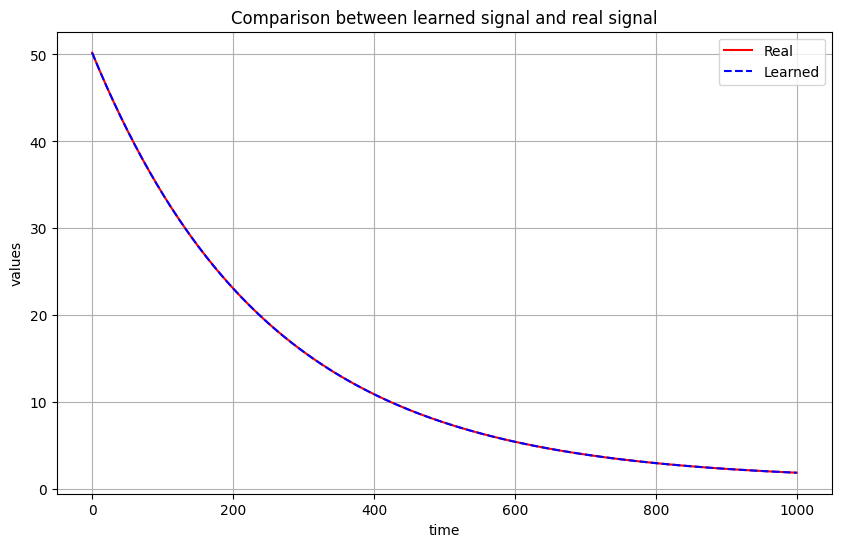

Model score: 1.000000


In [ ]:
# Plotto il grafico del modello reale e del modello appreso
plot_versus(t_val, t_train_test, x_learned, x_test)
print("Model score: %f" % model.score(x_test, t_train_test))

In [ ]:
coefficients = model.coefficients()
functions = ["1"]
curr = "F"
print("Array dei coefficienti:", coefficients)
if str(model.feature_library) == 'PolynomialLibrary()':
  for i in range(1,model.feature_library.degree):
    functions.append(curr)
    curr = curr+"*F"
print(functions)
invariant = ""
for i in range(0,len(functions)):
  invariant = invariant + str(coefficients[0][i]) + "*" + functions[i]
  if i < len(functions)-1 and coefficients[0][i+1]>0:
    invariant = invariant + "+"
  elif i == len(functions)-1:
    invariant = "Fp'==0 && F <= passout_th && F\'==" + invariant + " && tUpd<=Tpoll"

print(invariant)

Array dei coefficienti: [[ 4.00536364e-03 -4.00837282e-03  3.06016200e-06]]
['1', 'F']
Fp'==0 && F <= passout_th && F'==0.0040053636361905435*1-0.004008372819435243*F && tUpd<=Tpoll


In [ ]:
import xml.etree.ElementTree as ET

# Carica il file XML
tree = ET.parse('/content/drive/MyDrive/TESI AUTOMATA LEARNING/hri-w_ref.xml')
root = tree.getroot()

# Cerca la riga da modificare
for template in root.findall('.//template'):
    for location in template.findall('.//location'):
        for label in location.findall('.//label'):
            if label.attrib.get('kind') == 'invariant' and label.text.startswith('Fp\'==0 && F <= passout_th'):
                # Modifica il testo della riga
                label.text = invariant

tree.write('/content/drive/MyDrive/TESI AUTOMATA LEARNING/hri-w_ref_new.xml')


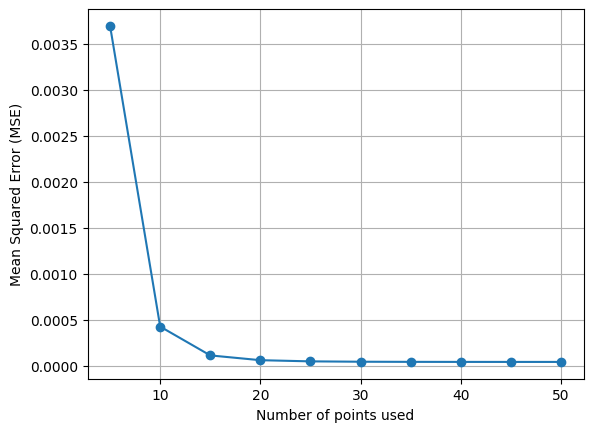

In [ ]:
mse_list = []

for num_point in range(5, 55, 5):
    t = np.linspace(0, 2000, num_point)
    x_train = np.array(busy_model(t, F_0))
    x_test = np.array(busy_model(t, F_0+0.2))
    model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.0005))
    model.fit(x_train, t)
    x_learned = model.simulate(np.array([x_test[0]]), t)
    mse = mean_squared_error(x_test, x_learned, squared=True)
    mse_list.append(mse)

plt.figure()
plt.plot(range(5, 55, 5), mse_list, marker='o')
plt.xlabel('Number of points used')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

In [ ]:
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].semilogy(threshold_scan, mse, "bo")
    axs[0].semilogy(threshold_scan, mse, "b")
    axs[0].set_ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    axs[0].set_xlabel(r"$\lambda$", fontsize=20)
    axs[0].tick_params(axis='both', which='major', labelsize=16)
    axs[0].grid(True)

    axs[1].semilogy(threshold_scan, mse_sim, "bo")
    axs[1].semilogy(threshold_scan, mse_sim, "b")
    axs[1].set_ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    axs[1].set_xlabel(r"$\lambda$", fontsize=20)
    axs[1].tick_params(axis='both', which='major', labelsize=16)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

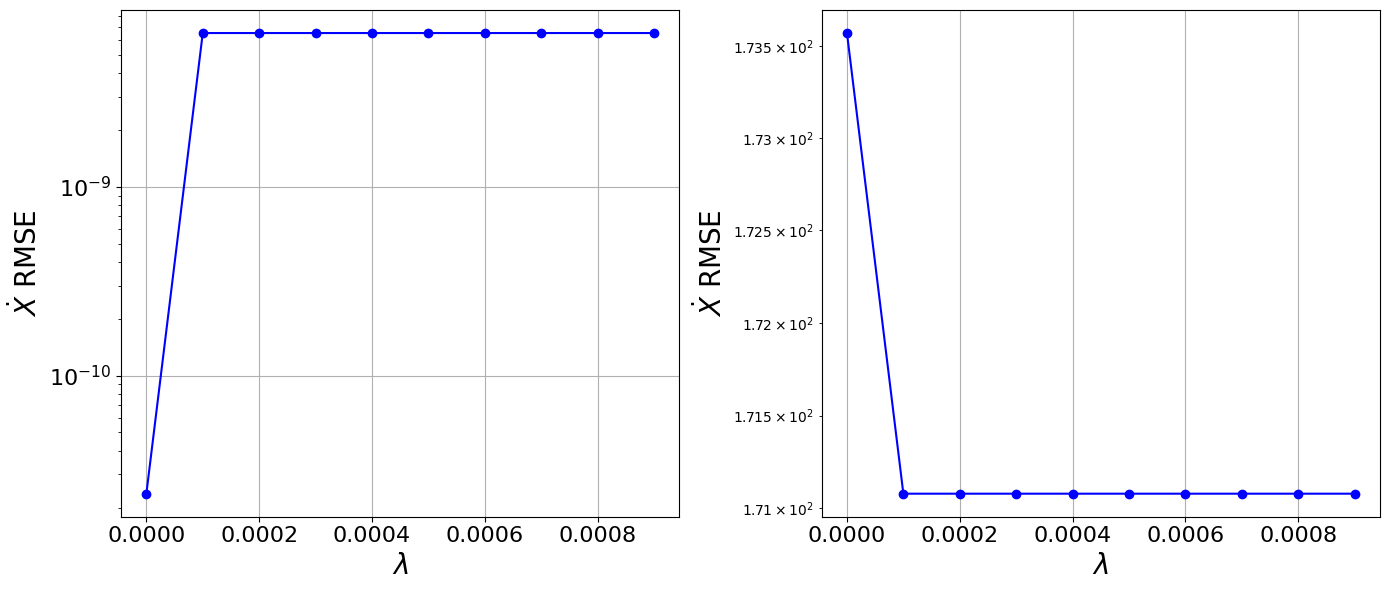

In [ ]:
# Plotting Pareto per vedere come varia RMSE al variare di lambda (ovvero la threshold dell'ottimizzatore STLSQ del modello PySindy)
threshold_scan = np.arange(0, 0.001, 0.0001)
coefs = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)
for i, threshold in enumerate(threshold_scan):
    opt = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(optimizer=opt)
    model.fit(x_train, t)
    coefs.append(model.coefficients())

plot_pareto(coefs, opt, model,
            threshold_scan, x_test, t)

### THERMOSTAT - on_model

In [ ]:
# Importo la classe Timestamp da L*SHA con le relative costanti
DAYS_PER_MONTH = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
CLOSED_R = 100.0
OFF_DISTR = (100.0, 1.0, 200)
ON_DISTR = (0.7, 0.01, 200)
class Timestamp:
    def __init__(self, y: int, m: int, d: int, h: int, min: int, sec: float):
        self.year = y
        self.month = m
        self.day = d
        self.hour = h
        self.min = min
        self.sec = sec

    @staticmethod
    def from_secs(secs: int):
        new_ts = Timestamp(int(secs / (365 * 24 * 3600)), 0, 0, 0, 0, 0)
        if secs > 365 * 24 * 3600:
            secs -= new_ts.year * 365 * 24 * 3600
        sum_d = 0
        for i, month_d in enumerate(DAYS_PER_MONTH):
            sum_d += month_d
            if secs <= sum_d * 24 * 3600:
                new_ts.month = i + 1
                secs -= (sum_d - month_d) * 24 * 3600
                break
        new_ts.day = int(secs / (24 * 3600)) + 1
        secs -= (new_ts.day - 1) * 24 * 3600
        new_ts.hour = int(secs / 3600)
        secs -= new_ts.hour * 3600
        new_ts.min = int(secs / 60)
        new_ts.sec = secs - new_ts.min * 60
        return new_ts

    def to_secs(self):
        months = sum(DAYS_PER_MONTH[:self.month - 1]) if self.month > 0 else 0
        days = self.year * 365 + months + self.day - 1 if self.day > 0 else 0
        minutes = self.hour * 60 + self.min
        seconds = minutes * 60 + self.sec
        return days * 24 * 3600 + seconds

    def __str__(self):
        return '{}/{}/{} {}:{}:{}'.format(self.day, self.month, self.year, self.hour, self.min, self.sec)

    def __hash__(self):
        return hash(str(self))

    def __eq__(self, other):
        return self.to_secs() == other.to_secs()

    def __ge__(self, other):
        return self.to_secs() >= other.to_secs()

    def __lt__(self, other):
        return self.to_secs() < other.to_secs()

    def __sub__(self, other):
        return self.to_secs() - other.to_secs()

In [ ]:
# Importo il modello
def on_model(interval: List[Timestamp], T_0: float):
    interval = [ts.to_secs() for ts in interval]
    coeff = CLOSED_R * ON_DISTR[0]
    return [coeff - (coeff - T_0) * math.exp(-(1 / CLOSED_R) * (t - interval[0])) for t in interval]
# Definisco la temperatura iniziale
T_0 = 15.2

In [ ]:
# Definisco l'intervallo di tempo
t_val = np.linspace(0, 500, 100)
t_train_test = np.linspace(0, 500, 100)

# Creazione di una lista di oggetti Timestamp
timestamps = []
for time in t_train_test:
    timestamp = Timestamp.from_secs(int(time))
    timestamps.append(timestamp)

# Utilizzo della lista di timestamp nella funzione on_model
x_train = np.array(on_model(timestamps, T_0))


x_test = np.array(on_model(timestamps, T_0+5))


# Creo un modello PySINDy polinomiale questa volta di grado 1
model = ps.SINDy(optimizer=ps.STLSQ(threshold=.0001), feature_names = ['T'])
print(model.get_params(deep=False))
model.fit(x_train, 100)
model.print()

{'differentiation_method': FiniteDifference(axis=-2), 'discrete_time': False, 'feature_library': PolynomialLibrary(), 'feature_names': ['T'], 'optimizer': STLSQ(threshold=0.0001), 't_default': 1}
(T)' = 0.035 1 + -0.001 T


In [ ]:
# Genero i valori dal modello appreso partendo dalo stesso valore iniziale del modello noto
init_val = np.array([x_test[0]])
x_learned = model.simulate(init_val, t_train_test)

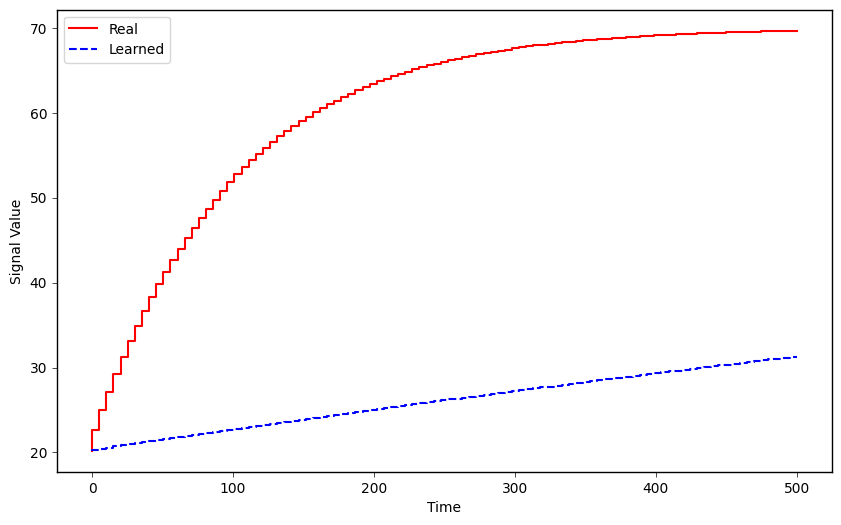

Model score: -0.487086


In [ ]:
# Plotta il grafico del modello reale e del modello appreso
plot_versus(t_val, t_train_test, x_learned, x_test)
print("Model score: %f" % model.score(x_test, t_train_test))

In [ ]:
def on(init,n):
  toReturn = []
  for i in range(0,n):
    if i == 0:
      toReturn.append(init)
    else:
      toReturn.append(3.421+0.951*toReturn[i-1])
  return toReturn

c = on(20.2, 100)

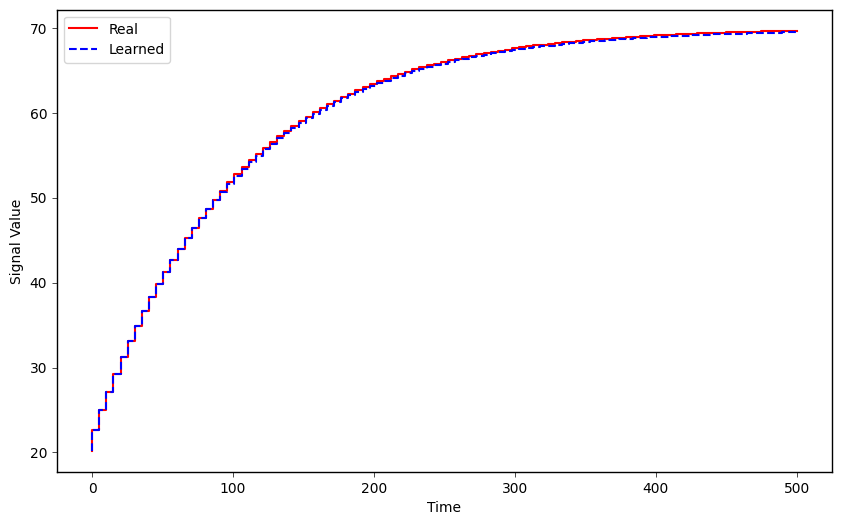

In [ ]:
plot_versus(t_val, t_train_test, c, x_test)

In [ ]:
!pip install pyuppaal
import pyuppaal as pyu
th = pyu.UModel("/content/drive/MyDrive/TESI AUTOMATA LEARNING/thermostat.xml")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.7/313.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
coefficients = model.coefficients()

functions = ["1"]
curr = "T"
print("Array dei coefficienti:", coefficients)
if str(model.feature_library) == 'PolynomialLibrary()':
  for i in range(1,model.feature_library.degree):
    functions.append(curr)
    curr = curr+"*T"
print(functions)
invariant = ""
for i in range(0,len(functions)):
  invariant = invariant + str(coefficients[0][i]) + "*" + functions[i]
  if i < len(functions)-1:
    invariant = invariant + "+"
  else:
    invariant = invariant + " && x<=T_s"

print(invariant)

Array dei coefficienti: [[3.42139175 0.95115657 0.        ]]
['1', 'T']
3.421391752630618*1+0.951156571861874*T && x<=T_s


In [ ]:
import xml.etree.ElementTree as ET

# Carica il file XML
tree = ET.parse('/content/drive/MyDrive/TESI AUTOMATA LEARNING/thermostat.xml')
root = tree.getroot()

# Cerca la riga da modificare
for template in root.findall('.//template'):
    for location in template.findall('.//location'):
        for label in location.findall('.//label'):
            if label.attrib.get('kind') == 'invariant' and label.text.startswith('T\'==K'):
                # Modifica il testo della riga
                label.text = 'T\'=='+invariant

tree.write('/content/drive/MyDrive/TESI AUTOMATA LEARNING/thermostat_new.xml')


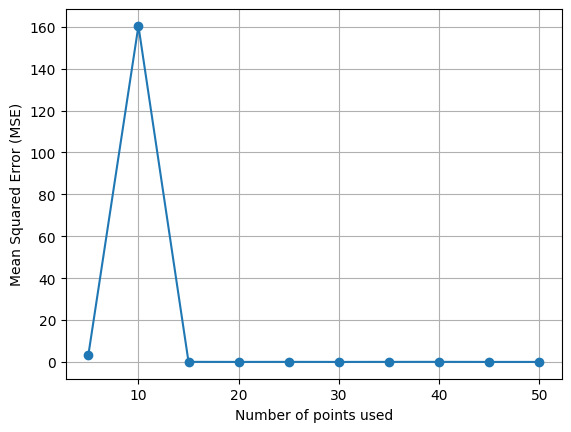

In [ ]:
mse_list = []

for num_points in range(5, 55, 5):  # valori da 5 a 101 con incrementi di 5
    t = np.linspace(0, 500, num_points)
    timestamps = []
    for time in t:
      timestamp = Timestamp.from_secs(int(time))
      timestamps.append(timestamp)
    x_train = np.array(on_model(timestamps, T_0))
    x_test = np.array(on_model(timestamps, T_0+5))
    model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.002))
    model.fit(x_train, t)
    x_learned = model.simulate(np.array([x_test[0]]), t)
    mse = mean_squared_error(x_test, x_learned, squared=True)
    mse_list.append(mse)

# Plot dell'errore quadratico medio rispetto al numero di punti utilizzati
plt.figure()
plt.plot(range(5, 55, 5), mse_list, marker='o')
plt.xlabel('Number of points used')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('')
plt.grid(True)
plt.show()


In [ ]:
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].semilogy(threshold_scan, mse, "bo")
    axs[0].semilogy(threshold_scan, mse, "b")
    axs[0].set_ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    axs[0].set_xlabel(r"$\lambda$", fontsize=20)
    axs[0].tick_params(axis='both', which='major', labelsize=16)
    axs[0].grid(True)

    axs[1].semilogy(threshold_scan, mse_sim, "bo")
    axs[1].semilogy(threshold_scan, mse_sim, "b")
    axs[1].set_ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    axs[1].set_xlabel(r"$\lambda$", fontsize=20)
    axs[1].tick_params(axis='both', which='major', labelsize=16)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.2) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.30000000000000004) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.6000000000000001) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too bi

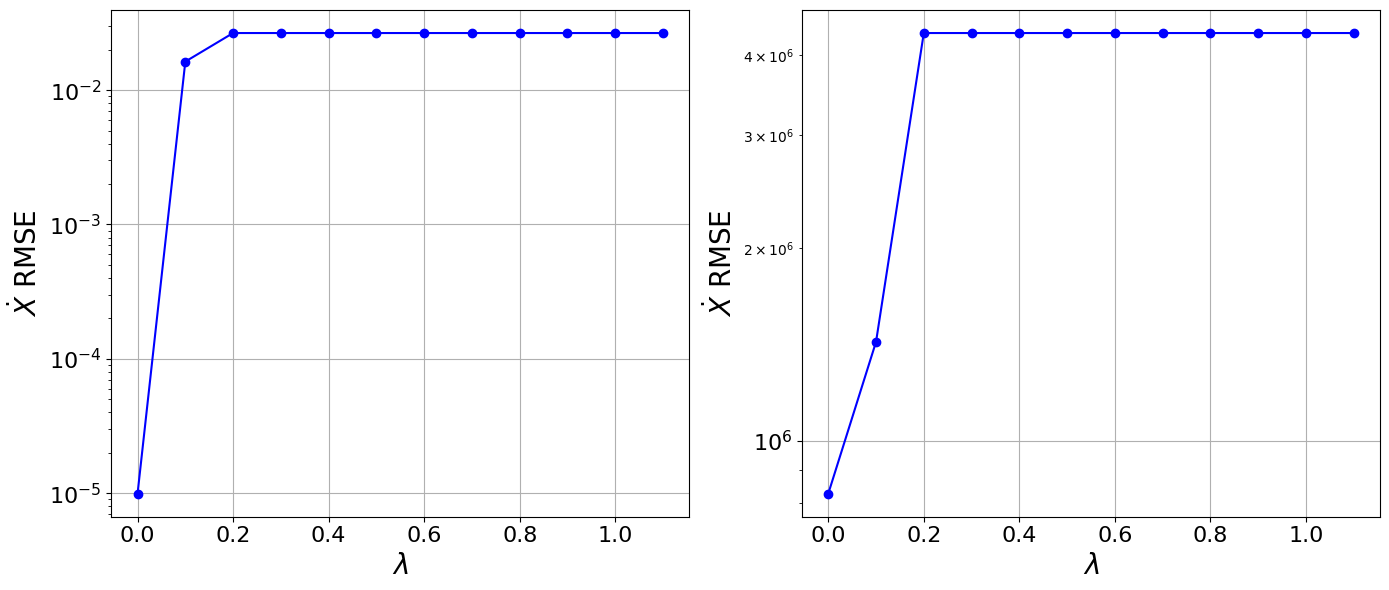

In [ ]:
# Plotting Pareto per vedere come varia RMSE al variare di lambda (ovvero la threshold dell'ottimizzatore STLSQ del modello PySindy)
threshold_scan = np.arange(0, 1.2, 0.1)
coefs = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)
for i, threshold in enumerate(threshold_scan):
    opt = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(optimizer=opt)
    model.fit(x_train, t)
    coefs.append(model.coefficients())

plot_pareto(coefs, opt, model,
            threshold_scan, x_test, t)

#Last verification step

Model Score: 0.984473846494077


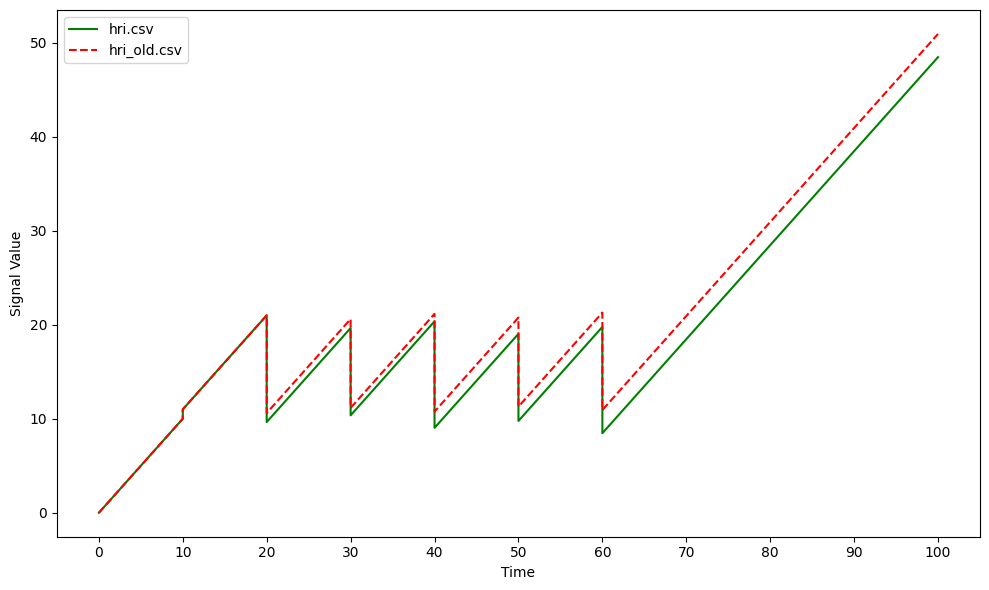

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

data_hri = pd.read_csv('/content/drive/MyDrive/TESI AUTOMATA LEARNING/HRI uppaal simualtions/hri.csv', header=None, names=['Time', 'Fp'])
data_hri_old = pd.read_csv('/content/drive/MyDrive/TESI AUTOMATA LEARNING/HRI uppaal simualtions/hri_old.csv', header=None, names=['Time', 'Fp'])

r2 = r2_score(data_hri['Fp'], data_hri_old['Fp'])

print(f'Model Score: {r2}')

plt.figure(figsize=(10, 6))

plt.plot(data_hri['Time'], data_hri['Fp'], label='hri.csv', color='green')

plt.plot(data_hri_old['Time'], data_hri_old['Fp'], label='hri_old.csv', color='red', linestyle='dashed')

plt.xticks(range(int(data_hri['Time'].min()), int(data_hri['Time'].max()) + 1, 10))

plt.xlabel('Time')
plt.ylabel('Signal Value')

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()


## Funzioni di libreria aggiuntive

### Funzioni candidate di libreria per l'approssimazione (qui usato solo Polinomiali)

In [ ]:
# Inizializza librerie polinomiali, cos/sin e reciproci+esponenziali
poly_library = ps.PolynomialLibrary()
fourier_library = ps.FourierLibrary()
library_functions = [lambda x: 1.0 / (x + 100), lambda x: np.exp(-x)]
library_function_names = [
    lambda x: "1.0 / (" + x + " + 100)",
    lambda x: "exp(-" + x + ")",
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names
)

# Inizializza input per ogni libreria
inputs_temp = np.tile([0, 1, 2, 3, 4], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 5))

# Escludo x, u0, u1 inputs per Fourier
inputs_per_library[1, 2] = 1
inputs_per_library[1, 3] = 1
inputs_per_library[1, 4] = 1

# Escludo y, z, u0 inputs per la Custom Library
inputs_per_library[2, 1] = 0
inputs_per_library[2, 2] = 0
inputs_per_library[2, 3] = 0

# Per fare prodotto tra polynomial e Fourier library
# e tra Fourier e Custom library.
tensor_array = [[1, 1, 0], [0, 1, 1]]

generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library, custom_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)